# A Motivating Example: Linear Regression

[Motivating Example](http://docs.pymc.io/notebooks/getting_started.html#A-Motivating-Example:-Linear-Regression)

In [2]:
import sys

In [3]:
sys.path.append("../") ## append directory where BDA directory is located

In [4]:
from BDA.plots import *
from BDA.stats import *

now importing: 
3. matplotlib.pyplot as plt

now importing: 
1. numpy as np 
2. from scipy import stats




In [5]:
%matplotlib inline

## Generating data
We can simulate some artificial data from this model using only NumPy’s `random` module, 
and then use PyMC3 to try to recover the corresponding parameters. 
We are intentionally generating the data to closely correspond the PyMC3 model structure.

In [6]:
#import numpy as np
#import matplotlib.pyplot as plt

# Initialize random number generator
np.random.seed(123)

# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0]*X1 + beta[1]*X2 + np.random.randn(size)*sigma

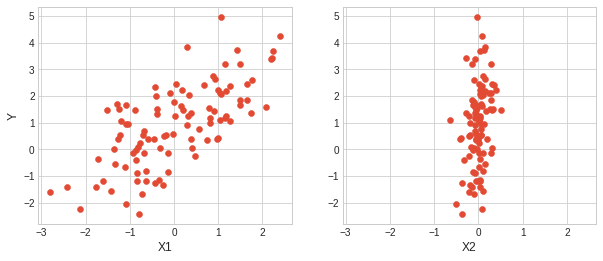

In [7]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,4))
axes[0].scatter(X1, Y)
axes[1].scatter(X2, Y)
axes[0].set_ylabel('Y'); axes[0].set_xlabel('X1'); axes[1].set_xlabel('X2');

## Model Specification

Specifying this model in PyMC3 is straightforward because the syntax is as close to the statistical notation. For the most part, each line of Python code corresponds to a line in the model notation above.

First, we import PyMC. We use the convention of importing it as pm.

In [7]:
import pymc3 as pm

In [8]:
basic_model = pm.Model() ## creates a new Model object which is a container for the model random variables.

with basic_model:

    # Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    sigma = pm.HalfNormal('sigma', sd=1)

    # Expected value of outcome
    mu = alpha + beta[0]*X1 + beta[1]*X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sd=sigma, observed=Y)

    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    sigma = pm.HalfNormal('sigma', sd=1)

The above code creates stochastic random variables with a Normal prior distributions for the regression coefficients with a mean of 0 and standard deviation of 10 for the regression coefficients, and a half-normal distribution for the standard deviation of the observations, $\sigma$. These are stochastic because their values are partly determined by its parents in the dependency graph of random variables, which for priors are simple constants, and partly random (or stochastic).

## Maximum a posteriori methods

The maximum a posteriori (MAP) estimate for a model, is the mode of the posterior distribution and is generally found using numerical optimization methods. This is often fast and easy to do, but only gives a point estimate for the parameters and can be biased if the mode isn’t representative of the distribution. PyMC3 provides this functionality with the `find_MAP` function.

Below we find the MAP for our original model. The MAP is returned as a parameter point, which is always represented by a Python dictionary of variable names to NumPy arrays of parameter values.

In [9]:
map_estimate = pm.find_MAP(model=basic_model)

map_estimate

Optimization terminated successfully.
         Current function value: 149.017982
         Iterations: 16
         Function evaluations: 21
         Gradient evaluations: 21


{'alpha': array(0.9065985497559482),
 'beta': array([ 0.94848602,  2.60705514]),
 'sigma_log_': array(-0.03278147017403066)}

By default, find_MAP uses the Broyden–Fletcher–Goldfarb–Shanno (BFGS) optimization algorithm to find the maximum of the log-posterior but also allows selection of other optimization algorithms from the scipy.optimize module. For example, below we use Powell’s method to find the MAP.

In [10]:
## Using Scipy
from scipy import optimize

map_estimate = pm.find_MAP(model=basic_model, fmin=optimize.fmin_powell)

map_estimate

Optimization terminated successfully.
         Current function value: 149.019762
         Iterations: 4
         Function evaluations: 176


{'alpha': array(0.90905218989771),
 'beta': array([ 0.95140146,  2.61437458]),
 'sigma_log_': array(-0.03000977520297042)}

NUTS requires a scaling matrix parameter, which is analogous to the variance parameter for the jump proposal distribution in Metropolis-Hastings, although NUTS uses it somewhat differently. The matrix gives the rough shape of the distribution so that NUTS does not make jumps that are too large in some directions and too small in other directions. It is important to set this scaling parameter to a reasonable value to facilitate efficient sampling. This is especially true for models that have many unobserved stochastic random variables or models with highly non-normal posterior distributions. Poor scaling parameters will slow down NUTS significantly, sometimes almost stopping it completely. A reasonable starting point for sampling can also be important for efficient sampling, but not as often.

Fortunately PyMC3 automatically initializes NUTS using another inference algorithm called ADVI (auto-diff variational inference). Moreover, PyMC3 will automatically assign an appropriate sampler if we don’t supply it via the `step` keyword argument (see below for an example of how to explicitly assign step methods).

In [13]:
#from scipy import optimize

with basic_model:
    # draw 500 posterior samples
    trace = pm.sample(draws=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -153.49: 100%|██████████| 200000/200000 [00:13<00:00, 14533.03it/s]
Finished [100%]: Average ELBO = -153.5
100%|██████████| 5000/5000 [00:04<00:00, 1050.65it/s]


In [12]:
trace

<MultiTrace: 1 chains, 100 iterations, 4 variables>

If we wanted to use the slice sampling algorithm to sigma instead of NUTS (which was assigned automatically), we could have specified this as the `step` argument for sample.

In [14]:

with basic_model:

    # obtain starting values via MAP
    start = pm.find_MAP(fmin=optimize.fmin_powell)

    # instantiate sampler
    step = pm.Slice()

    # draw 5000 posterior samples
    trace = pm.sample(draws = 5000, step=step, start=start)

  2%|▏         | 76/5000 [00:00<00:06, 751.38it/s]

Optimization terminated successfully.
         Current function value: 149.019762
         Iterations: 4
         Function evaluations: 176


100%|██████████| 5000/5000 [00:06<00:00, 775.58it/s]


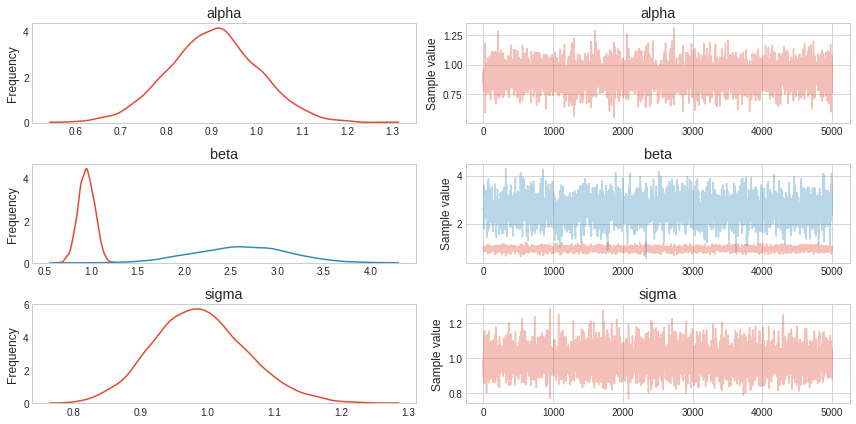

In [15]:
tmp = pm.traceplot(trace)

In [14]:
tmp

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000FCAA860>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000000000FBFEBA8>]], dtype=object)

The left column consists of a smoothed histogram (using kernel density estimation) of the marginal posteriors of each stochastic random variable while the right column contains the samples of the Markov chain plotted in sequential order. The beta variable, being vector-valued, produces two histograms and two sample traces, corresponding to both predictor coefficients.

In addition, the summary function provides a text-based output of common posterior statistics:

In [16]:
pm.summary(trace)


alpha:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.905            0.099            0.001            [0.710, 1.096]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.713          0.839          0.906          0.970          1.100


beta:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.949            0.088            0.002            [0.785, 1.122]
  2.607            0.509            0.014            [1.598, 3.562]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.779          0.890          0.948          1.010          1.118
  1.608          2.262          2.612   